# actual_connectedness.ipynb 
adapted code to allow for computing connectedness given an actual sequence of states

In [1]:
# Jupyter's default tab completion is broken right now;
# this seems to be a workaround until it's fixed, per
# https://github.com/jupyter/notebook/issues/3763#issuecomment-745701270
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import pyphi
import numpy as np
import matplotlib.pyplot as plt

import connectedness as con
import compute
from utils import get_substate
from networks import get_dynamics_from_sbs as sim

import adjacency
import grid_search

from pyphi.convert import sbn2sbs, sbs2sbn, to_2d, state2le_index
from pyphi.tpm import condition_tpm, marginalize_out


In [3]:
tqdm.pandas()

## Set up network

In [4]:
def build_weights(params):
    """Return the weight matrix for layers of grids (no vertex units)."""
    return adjacency.weighted_adjacency_matrix_input_and_system(
        n=params["layer_size"],
        n_layers=params["grid_layers"],
        # Grid
        w_lateral=params["grid_lateral"],
        w_self=params["grid_self"],
        w_in=params["grid_input"],
        k=params["k"],
        # Input array
        w_input_lateral=params["world_lateral"],
        w_input_self=params["world_self"],
        k_input=params["k"],
        # All
        toroidal=params["toroidal"],
    )


def build_network(params):
    W = build_weights(params)
    node_labels = [
        "iA",
        "iB",
        "iC",
        "iD",
        "A1",
        "B1",
        "C1",
        "D1",
        "sA",
        "sB",
        "sC",
        "sD",
    ]
    temp = np.ones(params["layer_size"] * 3) * params["temp_grid"]
    field = np.ones(params["layer_size"] * 3) * params["field_grid"]
    network = grid_search.build_network(
        params, W=W, field=field, temperature=temp, node_labels=node_labels
    )
    return network



In [5]:
def get_conditioned_tpms(network, input_states, input_indices):

    non_inputs = tuple(set(network.node_indices) - set(input_indices))

    return [
        np.squeeze(
            sbn2sbs(condition_tpm(network.tpm, input_indices, state)[..., non_inputs])
        )
        for state in input_states
    ]


def get_marginal_tpms(network, input_indices, tau):

    non_inputs = tuple(set(network.node_indices) - set(input_indices))
    marginal = np.squeeze(
        sbn2sbs(marginalize_out(input_indices, network.tpm)[..., non_inputs])
    )

    return [marginal] * tau


def get_input_constrained_tpms(conditioned_tpms):

    input_constrained_tpms = [conditioned_tpms[-1]]

    for tau, tpm in enumerate(reversed(conditioned_tpms[:-1])):
        input_constrained_tpms.append(np.matmul(tpm, input_constrained_tpms[tau]))

    return list(input_constrained_tpms)


def get_unconstrained_tpms(marginal_tpms):

    unconstrained_tpms = [marginal_tpms[0]]

    for tau, tpm in enumerate(marginal_tpms[1:]):
        unconstrained_tpms.append(np.matmul(tpm, unconstrained_tpms[tau]))

    return unconstrained_tpms


def get_subset_connectedness(
    subset_indices, subset_state, input_constrained_tpms, unconstrained_tpms, n_inputs
):

    translated_subset_indices = tuple([i - n_inputs for i in subset_indices])

    connectedness = []

    for conditioned_tpm, marginal_tpm in zip(
        input_constrained_tpms, unconstrained_tpms
    ):
        Pr_subsetstate_given_input = sbn2sbs(
            to_2d(sbs2sbn(conditioned_tpm))[..., translated_subset_indices]
        ).mean(0)[state2le_index(subset_state)]

        Pr_subsetstate = sbn2sbs(
            to_2d(sbs2sbn(marginal_tpm))[..., translated_subset_indices]
        ).mean(0)[state2le_index(subset_state)]

        # get intrinsic difference
        connectedness.append(np.log2(Pr_subsetstate_given_input / Pr_subsetstate))

    return connectedness

def get_change_pr_step(data):
    return np.sum(np.abs(data[:-1]-data[1:]),1)


def get_time_to_change(data):
    
    changes = get_change_pr_step(data)
    
    time_to_change = []
    
    t = 1
    for c in changes:
        if c == 0:
            t+=1
        else:
            time_to_change.append(t)
            t=1
    
    return time_to_change


def get_data_sample(data,t,tau,subset_indices,input_indices):
    
    subset_state = data[t,subset_indices]
    input_sequence = data[t-tau-1:t,input_indices]
    
    return subset_state,input_sequence

# Look at a simple example for the use of this notebook

In [69]:
# Define a network
n = 4
layers = 2

params = {
    "layer_size": n,
    "grid_layers": layers,
    "grid_input": 0.025,
    "grid_lateral": 0.2,
    "grid_self": 0.8,
    "world_lateral": 0.01,
    "world_self": 0.8,
    "temp_grid": 0.4,
    "field_grid": 0,
    "k": 1,
    "toroidal": True,
} 

network = build_network(params)

In [74]:
# set parameters and generate an exampl input sequence
subset_indices = (9, 10)
subset_state = (1,1)
input_indices = (0, 1, 2, 3)
input_sequence = [
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
    (0, 0, 0, 0),
]
tau = len(input_sequence)
n_inputs = len(input_indices)

In [75]:
# compute connectedness for the example data sequence

conditioned_tpms = get_conditioned_tpms(network, input_sequence, input_indices)
marginal_tpms = get_marginal_tpms(network, input_indices, tau)

input_constrained_tpms = get_input_constrained_tpms(conditioned_tpms)
unconstrained_tpms = get_unconstrained_tpms(marginal_tpms)

connectedness = get_subset_connectedness(subset_indices, subset_state, input_constrained_tpms, unconstrained_tpms, n_inputs)
connectedness

[6.406853007629834e-16,
 -0.00043690968615078113,
 -0.0011686608923166598,
 -0.0021290220939378392,
 -0.003266434488238495,
 -0.00453854829961189,
 -0.005910635096060357,
 -0.007354204462858831,
 -0.008845799216762774,
 -0.01036603766370783,
 -0.011898878103066892,
 -0.01343105341199604,
 -0.014951628460164179,
 -0.016451645159135487,
 -0.017923830837774334,
 -0.019362353689490405]

## Simulate some real data

In [24]:

# Prepare RNG
ENTROPY = 19283591005102385916723052837195786192730157108218751289951982
SS = np.random.SeedSequence(ENTROPY)
RNG = np.random.default_rng(SS)

data = sim(pyphi.convert.sbn2sbs(network.tpm), 0, 1000,RNG)

## Separate out data in the input array, and inspect its variability

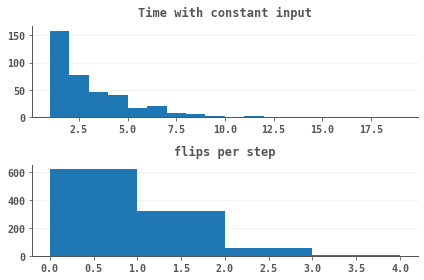

In [28]:
input_data_sequences = data[:,:4]

plt.subplot(211)
plt.hist(get_time_to_change(input_data_sequences),range(1,20))
plt.title('Time with constant input')

plt.subplot(212)
plt.hist(get_change_pr_step(input_data_sequences),range(5))
plt.title('flips per step')

plt.tight_layout()

## Get a sample of data, and compute connectedness

In [30]:
# define parameters to select the input data
t = 200
tau = 20
subset_indices = (9,10)
input_indices = (0,1,2,3)

subset_state, input_sequence = get_data_sample(data,t,tau,subset_indices,input_indices)

In [31]:
# compute connectedness for this data sample
conditioned_tpms = get_conditioned_tpms(network, input_sequence, input_indices)
marginal_tpms = get_marginal_tpms(network, input_indices, tau)

input_constrained_tpms = get_input_constrained_tpms(conditioned_tpms)
unconstrained_tpms = get_unconstrained_tpms(marginal_tpms)

connectedness = get_subset_connectedness(subset_indices, subset_state, input_constrained_tpms, unconstrained_tpms, n_inputs)

/home/bjuel/miniconda3/envs/matching/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


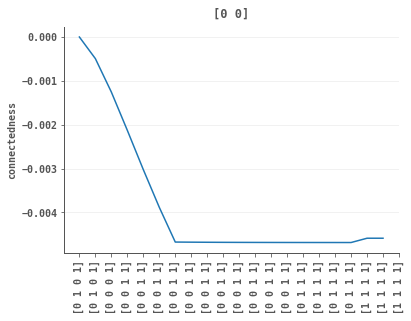

In [34]:
plt.plot(range(tau),connectedness)
plt.ylabel('connectedness')
plt.xticks(range(tau+1),input_sequence,rotation = 90)
plt.xlabel('input states in the past\n (present ---> past)')
plt.title(subset_state);

# Get connectedness for multiple samples to get an idea of domain connectedness


In [35]:
tau = 20
times = range(tau + 1, 1000, tau)
subset_indices = (9, 10)
input_indices = (0, 1, 2, 3)

structure_connectedness = []
for t in tqdm(list(times)):
    subset_state, input_sequence = get_data_sample(
        data, t, tau, subset_indices, input_indices
    )

    # compute connectedness for this data sample
    conditioned_tpms = get_conditioned_tpms(network, input_sequence, input_indices)
    marginal_tpms = get_marginal_tpms(network, input_indices, tau)

    input_constrained_tpms = get_input_constrained_tpms(conditioned_tpms)
    unconstrained_tpms = get_unconstrained_tpms(marginal_tpms)

    structure_connectedness.append(
        get_subset_connectedness(
            subset_indices,
            subset_state,
            input_constrained_tpms,
            unconstrained_tpms,
            n_inputs,
        )
    )

  0%|          | 0/49 [00:00<?, ?it/s]

Text(0, 0.5, 'connectedness')

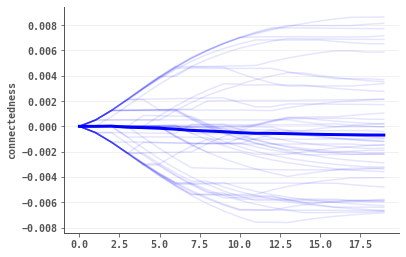

In [36]:
# plot the results
for c in structure_connectedness:
    plt.plot(range(tau),c,'b',alpha=0.1)
plt.plot(range(tau),np.mean(structure_connectedness,0),'b',linewidth=3)
plt.ylabel('connectedness')
plt.xlabel('tau (timesteps into the past)')

# Repeating the experiment, but with no structure in the world

In [37]:
# define a new network with no connectivity between world elments
n = 4
layers = 2

params = {
    "layer_size": n,
    "grid_layers": layers,
    "grid_input": 0.022,
    "grid_lateral": 0.01,
    "grid_self": 0.8,
    "world_lateral": 0,
    "world_self": 0,
    "temp_grid": 0.4,
    "field_grid": 0,
    "k": 1,
    "toroidal": True,
} 

network_no_structure = build_network(params)

# simulate data
data_no_structure = sim(pyphi.convert.sbn2sbs(network_no_structure.tpm), 0, 1000,RNG)

In [38]:
# compute connectedness
tau = 20
times = range(tau + 1, 1000, tau)
subset_indices = (9, 10)
input_indices = (0, 1, 2, 3)

no_structure_connectedness = []
for t in tqdm(list(times)):
    subset_state, input_sequence = get_data_sample(
        data_no_structure, t, tau, subset_indices, input_indices
    )

    # compute connectedness for this data sample
    conditioned_tpms_no_structure = get_conditioned_tpms(network_no_structure, input_sequence, input_indices)
    marginal_tpms_no_structure = get_marginal_tpms(network_no_structure, input_indices, tau)

    input_constrained_tpms_no_structure = get_input_constrained_tpms(conditioned_tpms_no_structure)
    unconstrained_tpms_no_structure = get_unconstrained_tpms(marginal_tpms_no_structure)

    no_structure_connectedness.append(
        get_subset_connectedness(
            subset_indices,
            subset_state,
            input_constrained_tpms_no_structure,
            unconstrained_tpms_no_structure,
            len(input_indices),
        )
    )

  0%|          | 0/49 [00:00<?, ?it/s]

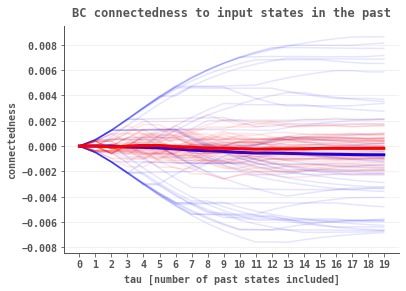

In [39]:
# plot the results (comparing connectedness with and without structure in the world)

for c in structure_connectedness:
    plt.plot(range(tau),c,'b',alpha=0.1)
plt.plot(range(tau),np.mean(structure_connectedness,0),'b',linewidth=3)
import matplotlib.pyplot as plt
for c in no_structure_connectedness:
    plt.plot(range(tau),c,'r',alpha=0.1)
plt.plot(range(tau),np.mean(no_structure_connectedness,0),'r',linewidth=3)
plt.ylabel('connectedness');
plt.xlabel('tau [number of past states included]')
plt.xticks(range(tau),range(tau))
plt.title('BC connectedness to input states in the past');

Notice that for these parameters, the mean connectedness (thick lines) is basically the same for a structured (blue) and an unstructured (red) world. The main difference between the two is that the variance in connectedness values is different (smaller for no structure)

# Trying the comparison for different values of input strength 

## input strength: 0.2

In [40]:
n = 4
layers = 2

tau = 20
times = range(tau + 1, 1000, tau)
subset_indices = (9, 10)
input_indices = (0, 1, 2, 3)

# Prepare RNG
ENTROPY = 19283591005102385916723052837195786192730157108218751289951982
SS = np.random.SeedSequence(ENTROPY)
RNG = np.random.default_rng(SS)

params = {
    "layer_size": n,
    "grid_layers": layers,
    "grid_input": 0.2,
    "grid_lateral": 0.01,
    "grid_self": 0.8,
    "world_lateral": 0.01,
    "world_self": 0.8,
    "temp_grid": 0.4,
    "field_grid": 0,
    "k": 1,
    "toroidal": True,
} 

network = build_network(params)

params["world_self"] = 0
params["world_lateral"] = 0
network_no_structure = build_network(params)

# simulate data
data = sim(pyphi.convert.sbn2sbs(network.tpm), 0, 1000,RNG)
data_no_structure = sim(pyphi.convert.sbn2sbs(network_no_structure.tpm), 0, 1000,RNG)

# computing connectedness
# for structured world
structure_connectedness = []
for t in tqdm(list(times)):
    subset_state, input_sequence = get_data_sample(
        data, t, tau, subset_indices, input_indices
    )

    # compute connectedness for this data sample
    conditioned_tpms = get_conditioned_tpms(network, input_sequence, input_indices)
    marginal_tpms = get_marginal_tpms(network, input_indices, tau)

    input_constrained_tpms = get_input_constrained_tpms(conditioned_tpms)
    unconstrained_tpms = get_unconstrained_tpms(marginal_tpms)

    structure_connectedness.append(
        get_subset_connectedness(
            subset_indices,
            subset_state,
            input_constrained_tpms,
            unconstrained_tpms,
            n_inputs,
        )
    )

# for unstructured world
no_structure_connectedness = []
for t in tqdm(list(times)):
    subset_state, input_sequence = get_data_sample(
        data_no_structure, t, tau, subset_indices, input_indices
    )

    # compute connectedness for this data sample
    conditioned_tpms_no_structure = get_conditioned_tpms(network_no_structure, input_sequence, input_indices)
    marginal_tpms_no_structure = get_marginal_tpms(network_no_structure, input_indices, tau)

    input_constrained_tpms_no_structure = get_input_constrained_tpms(conditioned_tpms_no_structure)
    unconstrained_tpms_no_structure = get_unconstrained_tpms(marginal_tpms_no_structure)

    no_structure_connectedness.append(
        get_subset_connectedness(
            subset_indices,
            subset_state,
            input_constrained_tpms_no_structure,
            unconstrained_tpms_no_structure,
            len(input_indices),
        )
    )

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

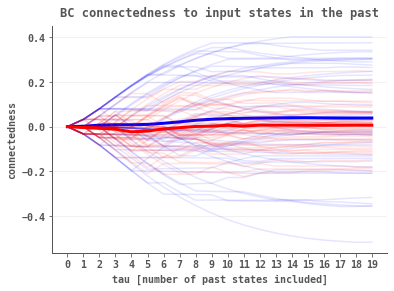

In [41]:
for c in structure_connectedness:
    plt.plot(range(tau),c,'b',alpha=0.1)
plt.plot(range(tau),np.mean(structure_connectedness,0),'b',linewidth=3)
import matplotlib.pyplot as plt
for c in no_structure_connectedness:
    plt.plot(range(tau),c,'r',alpha=0.1)
plt.plot(range(tau),np.mean(no_structure_connectedness,0),'r',linewidth=3)
plt.ylabel('connectedness');
plt.xlabel('tau [number of past states included]')
plt.xticks(range(tau),range(tau))
plt.title('BC connectedness to input states in the past');

# input strength: 0.5

In [42]:
n = 4
layers = 2

tau = 20
times = range(tau + 1, 1000, tau)
subset_indices = (9, 10)
input_indices = (0, 1, 2, 3)

# Prepare RNG
ENTROPY = 19283591005102385916723052837195786192730157108218751289951982
SS = np.random.SeedSequence(ENTROPY)
RNG = np.random.default_rng(SS)

params = {
    "layer_size": n,
    "grid_layers": layers,
    "grid_input": 0.5,
    "grid_lateral": 0.01,
    "grid_self": 0.8,
    "world_lateral": 0.01,
    "world_self": 0.8,
    "temp_grid": 0.4,
    "field_grid": 0,
    "k": 1,
    "toroidal": True,
} 

network = build_network(params)

params["world_self"] = 0
params["world_lateral"] = 0
network_no_structure = build_network(params)

# simulate data
data = sim(pyphi.convert.sbn2sbs(network.tpm), 0, 1000,RNG)
data_no_structure = sim(pyphi.convert.sbn2sbs(network_no_structure.tpm), 0, 1000,RNG)

# computing connectedness
# for structured world
structure_connectedness = []
for t in tqdm(list(times)):
    subset_state, input_sequence = get_data_sample(
        data, t, tau, subset_indices, input_indices
    )

    # compute connectedness for this data sample
    conditioned_tpms = get_conditioned_tpms(network, input_sequence, input_indices)
    marginal_tpms = get_marginal_tpms(network, input_indices, tau)

    input_constrained_tpms = get_input_constrained_tpms(conditioned_tpms)
    unconstrained_tpms = get_unconstrained_tpms(marginal_tpms)

    structure_connectedness.append(
        get_subset_connectedness(
            subset_indices,
            subset_state,
            input_constrained_tpms,
            unconstrained_tpms,
            n_inputs,
        )
    )

# for unstructured world
no_structure_connectedness = []
for t in tqdm(list(times)):
    subset_state, input_sequence = get_data_sample(
        data_no_structure, t, tau, subset_indices, input_indices
    )

    # compute connectedness for this data sample
    conditioned_tpms_no_structure = get_conditioned_tpms(network_no_structure, input_sequence, input_indices)
    marginal_tpms_no_structure = get_marginal_tpms(network_no_structure, input_indices, tau)

    input_constrained_tpms_no_structure = get_input_constrained_tpms(conditioned_tpms_no_structure)
    unconstrained_tpms_no_structure = get_unconstrained_tpms(marginal_tpms_no_structure)

    no_structure_connectedness.append(
        get_subset_connectedness(
            subset_indices,
            subset_state,
            input_constrained_tpms_no_structure,
            unconstrained_tpms_no_structure,
            len(input_indices),
        )
    )

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

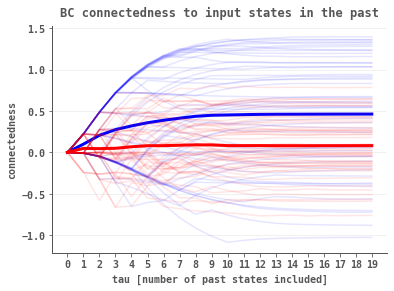

In [43]:
for c in structure_connectedness:
    plt.plot(range(tau),c,'b',alpha=0.1)
plt.plot(range(tau),np.mean(structure_connectedness,0),'b',linewidth=3)
import matplotlib.pyplot as plt
for c in no_structure_connectedness:
    plt.plot(range(tau),c,'r',alpha=0.1)
plt.plot(range(tau),np.mean(no_structure_connectedness,0),'r',linewidth=3)
plt.ylabel('connectedness');
plt.xlabel('tau [number of past states included]')
plt.xticks(range(tau),range(tau))
plt.title('BC connectedness to input states in the past');

# Experimenting with dataframe representation

In [9]:
def get_timevarying_connectedness(
    network, data, times, tau, input_indices, mechanisms, purviews=None
):

    content = []
    for t in tqdm(times):
        input_sequence = data[t - tau - 1 : t - 1, input_indices]
        state = data[t, :]

        system_indices = tuple(set(network.node_indices) - set(input_indices))
        system = pyphi.subsystem.Subsystem(network, tuple(state), system_indices)
        ces = pyphi.compute.ces(system, mechanisms, purviews)

        # compute connectedness for this data sample
        conditioned_tpms = get_conditioned_tpms(network, input_sequence, input_indices)
        marginal_tpms = get_marginal_tpms(network, input_indices, tau)

        input_constrained_tpms = get_input_constrained_tpms(conditioned_tpms)
        unconstrained_tpms = get_unconstrained_tpms(marginal_tpms)

        content.extend(
            [
                pd.DataFrame.from_dict(
                    {
                        (
                            t,
                            -(tt + 1),
                            concept.mechanism,
                            tuple(state[m] for m in concept.mechanism),
                            tuple(input_sequence[-(tt + 1), :]),
                        ): pd.Series(
                            {
                                "connectedness": connectedness,
                                "cause phi": concept.cause.phi,
                                "cause purview": concept.cause.purview,
                                "cause maximal state": concept.cause.maximal_state,
                                "cause actual state": tuple(
                                    data[t - 1, concept.cause.purview]
                                ),
                                "congruent": any(
                                    [
                                        tuple(s)
                                        == tuple(data[t - 1, concept.cause.purview])
                                        for s in concept.cause.maximal_state
                                    ]
                                ),
                            }
                        )
                        for tt, connectedness in enumerate(
                            get_subset_connectedness(
                                concept.cause.purview,
                                tuple(data[t - 1, concept.cause.purview]),
                                input_constrained_tpms,
                                unconstrained_tpms,
                                len(input_indices),
                            )
                        )
                    },
                    orient="index",
                )
                for concept in ces
            ]
        )

    df = pd.concat(content)
    df.index.names = ["t", "tau", "mechanism", "mech state", "input state"]
    return df

In [121]:
# creating a new network
n = 4
layers = 2

params = {
    "layer_size": n,
    "grid_layers": layers,
    "grid_input": 0.8,
    "grid_lateral": 0.2,
    "grid_self": 0.8,
    "world_lateral": 0.2,
    "world_self": 0.8,
    "temp_grid": 0.4,
    "field_grid": 0,
    "k": 1,
    "toroidal": True,
} 

network = build_network(params)

params["world_lateral"] = 0
params["world_self"] = 0
network_ns = build_network(params)


In [ ]:


# simulate data
# Prepare RNG
ENTROPY = 19283591005102385916723052837195786192730157108218751289951982
SS = np.random.SeedSequence(ENTROPY)
RNG = np.random.default_rng(SS)

time = 1000
data = sim(pyphi.convert.sbn2sbs(network.tpm), 0, time,RNG)
data_ns = sim(pyphi.convert.sbn2sbs(network_ns.tpm), 0, time,RNG)


In [12]:
max_tau = 25
times = list(range(max_tau+1,time,5))
inputs = (0, 1, 2, 3)
mechanisms = ((5,), (6,), (5, 6), (9,), (10,), (11,), (9, 10), (10, 11), (9, 10, 11))
purviews = tuple(pyphi.utils.powerset((5, 6, 7, 9, 10, 11), nonempty=True, max_size=3))

df = get_timevarying_connectedness(
    network, data, times, max_tau, inputs, mechanisms, purviews,
)

df_ns = get_timevarying_connectedness(
    network_ns, data_ns, times, max_tau, inputs, mechanisms, purviews,
)

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

In [13]:
df.to_csv('data/connectedness/actual-connectedness_structure_strong-input.csv')
df_ns.to_csv('data/connectedness/actual-connectedness_no-structure_strong-input.csv')

In [14]:
df.head(45)

connectedness  cause phi  \
t  tau mechanism mech state input state                              
26 -1  (5,)      (0,)       (0, 0, 1, 0)      -0.379435   0.469477   
   -2  (5,)      (0,)       (0, 0, 1, 0)      -0.644818   0.469477   
   -3  (5,)      (0,)       (0, 0, 1, 1)      -0.834941   0.469477   
   -4  (5,)      (0,)       (0, 0, 1, 1)      -0.974588   0.469477   
   -5  (5,)      (0,)       (0, 0, 1, 1)      -1.079363   0.469477   
   -6  (5,)      (0,)       (0, 1, 1, 1)      -0.897189   0.469477   
   -7  (5,)      (0,)       (0, 1, 1, 1)      -0.789926   0.469477   
   -8  (5,)      (0,)       (0, 1, 0, 0)      -0.867061   0.469477   
   -9  (5,)      (0,)       (0, 1, 0, 0)      -0.931913   0.469477   
   -10 (5,)      (0,)       (0, 1, 0, 0)      -0.988092   0.469477   
   -11 (5,)      (0,)       (0, 1, 0, 0)      -1.036679   0.469477   
   -12 (5,)      (0,)       (0, 1, 0, 0)      -1.078531   0.469477   
   -13 (5,)      (0,)       (0, 1, 0, 0)      -1.114449   0.469477   
   -14 (5,)      (0,)       (0, 1, 0, 0)      -1.145166   0.469477   
   -15 (5,)      (0,)       (0, 1, 0, 0)      -1.171343   0.469477   
   -16 (5,)      (0,)       (0, 1, 0, 0)      -1.193577   0.469477   
   -17 (5,)      (0,)       (1, 0, 0, 0)      -1.216007   0.469477   
   -18 (5,)      (0,)       (1, 0, 0, 0)      -1.235827   0.469477   
   -19 (5,)      (0,)       (1, 0, 0, 0)      -1.252297   0.469477   
   -20 (5,)      (0,)       (1, 0, 0, 1)      -1.248408   0.469477   
   -21 (5,)      (0,)       (1, 0, 0, 1)      -1.247955   0.469477   
   -22 (5,)      (0,)       (1, 0, 0, 1)      -1.248651   0.469477   
   -23 (5,)      (0,)       (1, 0, 0, 1)      -1.249650   0.469477   
   -24 (5,)      (0,)       (1, 0, 0, 0)      -1.258831   0.469477   
   -25 (5,)      (0,)       (0, 0, 0, 0)      -1.273629   0.469477   
   -1  (6,)      (1,)       (0, 0, 1, 0)       0.300137   0.819886   
   -2  (6,)      (1,)       (0, 0, 1, 0)       0.395314   0.819886   
   -3  (6,)      (1,)       (0, 0, 1, 1)       0.486585   0.819886   
   -4  (6,)      (1,)       (0, 0, 1, 1)       0.541413   0.819886   
   -5  (6,)      (1,)       (0, 0, 1, 1)       0.577274   0.819886   
   -6  (6,)      (1,)       (0, 1, 1, 1)       0.640031   0.819886   
   -7  (6,)      (1,)       (0, 1, 1, 1)       0.682236   0.819886   
   -8  (6,)      (1,)       (0, 1, 0, 0)       0.632142   0.819886   
   -9  (6,)      (1,)       (0, 1, 0, 0)       0.597423   0.819886   
   -10 (6,)      (1,)       (0, 1, 0, 0)       0.571749   0.819886   
   -11 (6,)      (1,)       (0, 1, 0, 0)       0.551997   0.819886   
   -12 (6,)      (1,)       (0, 1, 0, 0)       0.536335   0.819886   
   -13 (6,)      (1,)       (0, 1, 0, 0)       0.523641   0.819886   
   -14 (6,)      (1,)       (0, 1, 0, 0)       0.513200   0.819886   
   -15 (6,)      (1,)       (0, 1, 0, 0)       0.504538   0.819886   
   -16 (6,)      (1,)       (0, 1, 0, 0)       0.497316   0.819886   
   -17 (6,)      (1,)       (1, 0, 0, 0)       0.489411   0.819886   
   -18 (6,)      (1,)       (1, 0, 0, 0)       0.482808   0.819886   
   -19 (6,)      (1,)       (1, 0, 0, 0)       0.477477   0.819886   
   -20 (6,)      (1,)       (1, 0, 0, 1)       0.478560   0.819886   

                                         cause purview cause maximal state  \
t  tau mechanism mech state input state                                      
26 -1  (5,)      (0,)       (0, 0, 1, 0)          (5,)               [[0]]   
   -2  (5,)      (0,)       (0, 0, 1, 0)          (5,)               [[0]]   
   -3  (5,)      (0,)       (0, 0, 1, 1)          (5,)               [[0]]   
   -4  (5,)      (0,)       (0, 0, 1, 1)          (5,)               [[0]]   
   -5  (5,)      (0,)       (0, 0, 1, 1)          (5,)               [[0]]   
   -6  (5,)      (0,)       (0, 1, 1, 1)          (5,)               [[0]]   
   -7  (5,)      (0,)       (0, 1, 1, 1)          (5,)               [[0]]   
   -8  (5,)      (0,)       (0, 1, 0, 0)         

In [49]:
df_reset = df.reset_index()
df_reset.loc[(df_reset.mechanism ==(9,10)) & (df_reset['mech state']==(1,0)) & ~(df_reset['congruent'])]

,t,tau,mechanism,mech state,input state,connectedness,cause phi,cause purview,cause maximal state,cause actual state,congruent
375,31,-1,"(9, 10)","(1, 0)","(1, 0, 1, 1)",3.203427e-16,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
376,31,-2,"(9, 10)","(1, 0)","(1, 0, 1, 1)",-1.765852e-01,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
377,31,-3,"(9, 10)","(1, 0)","(1, 0, 0, 1)",-1.605152e-01,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
378,31,-4,"(9, 10)","(1, 0)","(1, 0, 0, 1)",-1.656996e-01,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
379,31,-5,"(9, 10)","(1, 0)","(1, 0, 1, 0)",-2.149455e-01,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
...,...,...,...,...,...,...,...,...,...,...,...
43370,986,-21,"(9, 10)","(1, 0)","(0, 1, 1, 1)",2.137769e-02,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
43371,986,-22,"(9, 10)","(1, 0)","(0, 1, 1, 1)",6.424049e-03,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
43372,986,-23,"(9, 10)","(1, 0)","(0, 1, 1, 1)",-6.240166e-03,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False
43373,986,-24,"(9, 10)","(1, 0)","(0, 1, 1, 0)",-4.066145e-03,0.071826,"(9, 10)","[[0, 1]]","(1, 0)",False


In [18]:
import seaborn as sb

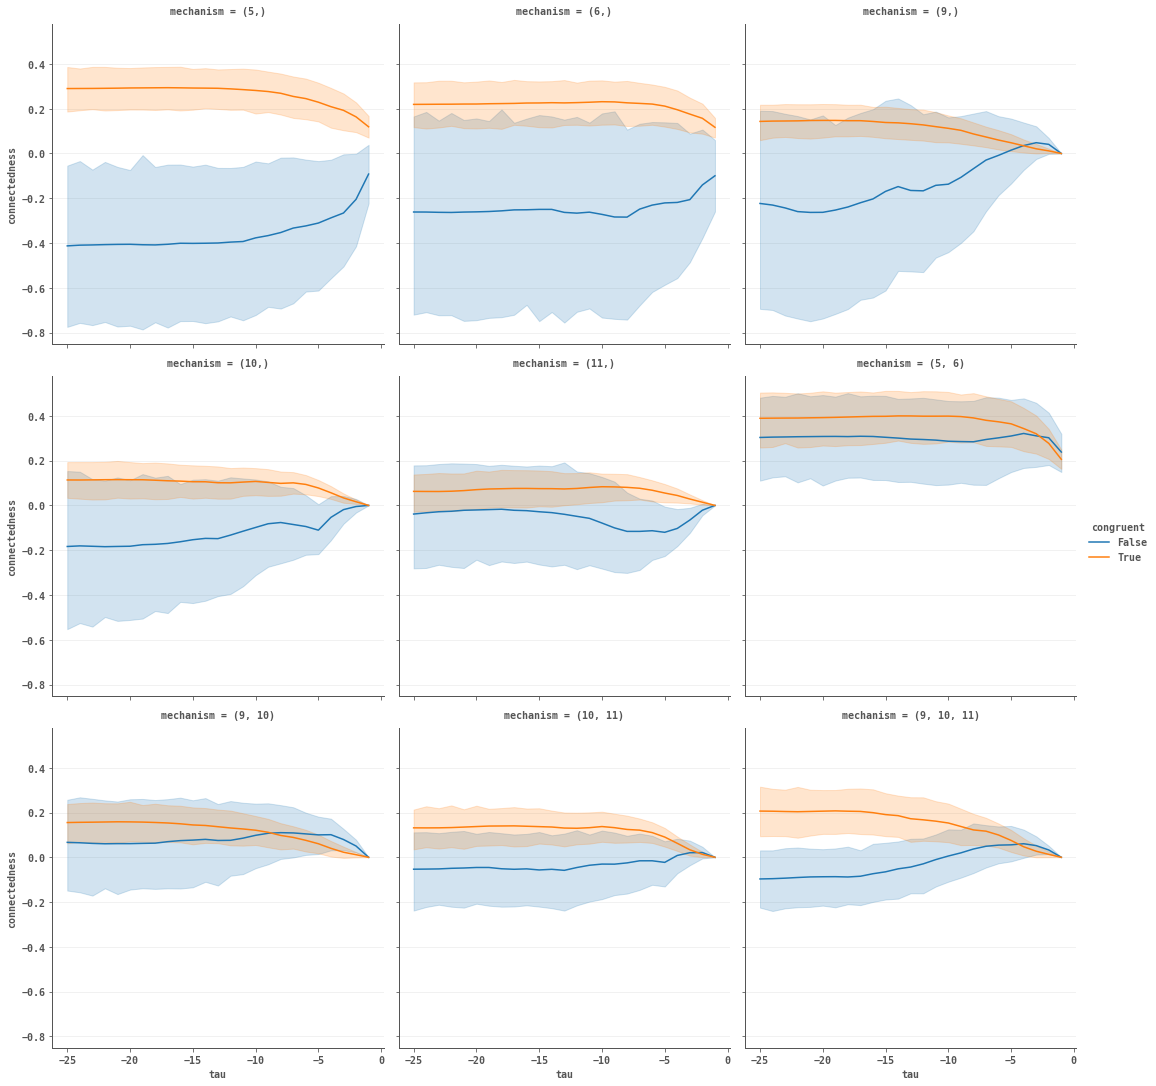

In [56]:
sb.relplot(
    data=df_reset, kind="line",
    x="tau", y="connectedness", 
    hue="congruent",col="mechanism",
    col_wrap = 3, facet_kws=dict(sharey=True)
)

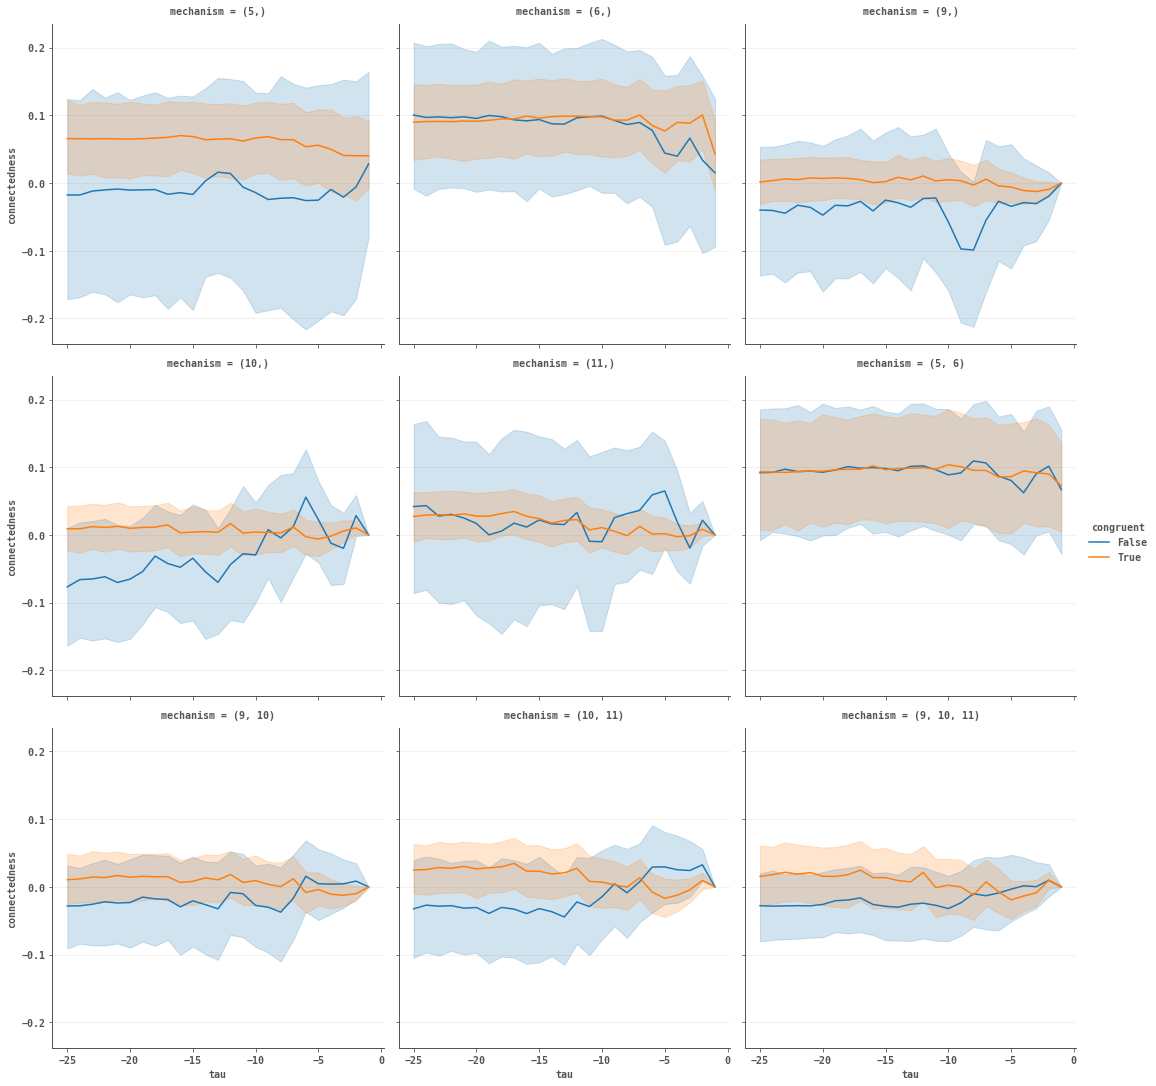

In [57]:
df_reset_ns = df_ns.reset_index()
sb.relplot(
    data=df_reset_ns, kind="line",
    x="tau", y="connectedness", 
    hue="congruent",col="mechanism",
    col_wrap = 3, facet_kws=dict(sharey=True)
)

In [12]:
df1 = pd.read_csv('data/connectedness/actual-connectedness_structure_strong-input.csv')
df2 = pd.read_csv('data/connectedness/actual-connectedness_no-structure_strong-input.csv')

In [28]:
df1.loc[(df1.mechanism =='(9, 10)')]

,t,tau,mechanism,mech state,input state,connectedness,cause phi,cause purview,cause maximal state,cause actual state,congruent
150,26,-1,"(9, 10)","(1, 1)","(0, 0, 1, 0)",-9.610280e-16,0.047139,"(9,)",[[1]],"(1,)",True
151,26,-2,"(9, 10)","(1, 1)","(0, 0, 1, 0)",-7.253899e-02,0.047139,"(9,)",[[1]],"(1,)",True
152,26,-3,"(9, 10)","(1, 1)","(0, 0, 1, 1)",-1.594846e-01,0.047139,"(9,)",[[1]],"(1,)",True
153,26,-4,"(9, 10)","(1, 1)","(0, 0, 1, 1)",-2.420067e-01,0.047139,"(9,)",[[1]],"(1,)",True
154,26,-5,"(9, 10)","(1, 1)","(0, 0, 1, 1)",-3.140869e-01,0.047139,"(9,)",[[1]],"(1,)",True
...,...,...,...,...,...,...,...,...,...,...,...
43820,996,-21,"(9, 10)","(0, 0)","(1, 1, 1, 1)",-8.238224e-02,0.047139,"(9,)",[[0]],"(0,)",True
43821,996,-22,"(9, 10)","(0, 0)","(1, 1, 1, 1)",-1.196392e-01,0.047139,"(9,)",[[0]],"(0,)",True
43822,996,-23,"(9, 10)","(0, 0)","(1, 1, 1, 1)",-1.489504e-01,0.047139,"(9,)",[[0]],"(0,)",True
43823,996,-24,"(9, 10)","(0, 0)","(1, 1, 1, 1)",-1.719018e-01,0.047139,"(9,)",[[0]],"(0,)",True


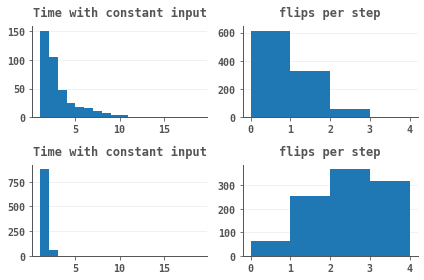

In [30]:
input_data_sequences = data[:,:4]
input_data_sequences_ns = data_ns[:,:4]

plt.subplot(221)
plt.hist(get_time_to_change(input_data_sequences),range(1,20))
plt.title('Time with constant input')

plt.subplot(222)
plt.hist(get_change_pr_step(input_data_sequences),range(5))
plt.title('flips per step')

plt.subplot(223)
plt.hist(get_time_to_change(input_data_sequences_ns),range(1,20))
plt.title('Time with constant input')

plt.subplot(224)
plt.hist(get_change_pr_step(input_data_sequences_ns),range(5))
plt.title('flips per step')

plt.tight_layout()

In [32]:
data[100:120,:]

array([[0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]])

In [128]:
# creating a new network
n = 4
layers = 2

params = {
    "layer_size": n,
    "grid_layers": layers,
    "grid_input": 0.7,
    "grid_lateral": 0.2,
    "grid_self": 0.8,
    "world_lateral": 0.2,
    "world_self": 0.8,
    "temp_grid": 0.4,
    "field_grid": 0,
    "k": 1,
    "toroidal": True,
} 

network = build_network(params)

params["world_lateral"] = 0
params["world_self"] = 0
network_ns = build_network(params)


In [129]:
tpm = network.tpm

(<Figure size 648x216 with 1 Axes>,
 <AxesSubplot:title={'center':'State distribution'}, xlabel='state', ylabel='Pr(state)'>)

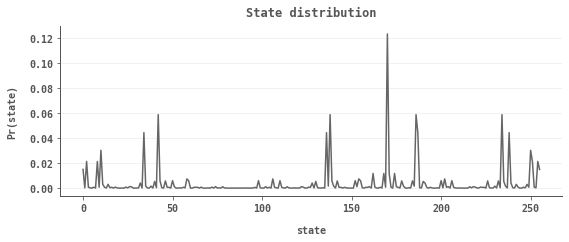

In [130]:
import extrinsic_information as ei
import visualization as viz
viz.plot_distribution(ei.get_stationary_distribution(np.squeeze(condition_tpm(tpm,(0,1,2,3),(0,1,0,1))[...,(4,5,6,7,8,9,10,11)])))

In [131]:
t = 25
s = 50
clamped_tpm_hom = np.zeros((t+1,8,s))
clamped_tpm_het = np.zeros((t+1,8,s))

for i in range(s):
    clamped_tpm_hom[:,:,i] = sim(sbn2sbs(np.squeeze(condition_tpm(tpm,(0,1,2,3),(0,0,0,0))[...,(4,5,6,7,8,9,10,11)])),25,t)
    clamped_tpm_het[:,:,i] = sim(sbn2sbs(np.squeeze(condition_tpm(tpm,(0,1,2,3),(1,0,1,0))[...,(4,5,6,7,8,9,10,11)])),25,t)

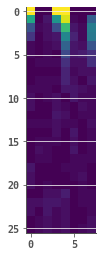

In [132]:
plt.imshow(np.mean(clamped_tpm_hom,2),vmin=0,vmax=1)

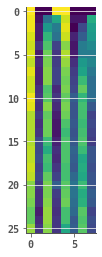

In [133]:
plt.imshow(np.mean(clamped_tpm_het,2),vmin=0,vmax=1)

In [134]:
clamped_tpm_het[0]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 